In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

# 2. 데이터 불러오기
df = pd.read_csv('20250626_174718_customer_data_balanced.csv')
df.head()


,Age,Tenure,MonthlySpending_KRW,ContractType,CustomerServiceCalls,IsChurn
0,56,29,249010,1,6,0
1,69,44,54542,1,6,0
2,46,53,30651,1,1,0
3,32,24,119239,0,5,1
4,60,58,361075,1,1,0


In [120]:
# 피쳐 생성

# 연령대 구간화 (예: 20/30/40/50/60대 이상)
df['Age_bin'] = pd.cut(df['Age'], bins=[0,30,40,50,60,100], labels=False)

# 월지출 상/하 구간 (중앙값 기준)
df['HighSpending'] = (df['MonthlySpending_KRW'] > df['MonthlySpending_KRW'].median()).astype(int)

# 콜/가입개월 비율 (서비스콜 비율)
df['Call_per_month'] = df['CustomerServiceCalls'] / (df['Tenure'] + 1)

# 월지출*가입개월 (총 누적지출)
df['TotalSpending'] = df['MonthlySpending_KRW'] * df['Tenure']

# Tenure 구간화 (가입기간대: 0~12, 13~36, 37~60, 61~)
df['Tenure_bin'] = pd.cut(df['Tenure'], bins=[-1,12,36,60,100], labels=False)

# 로그변환: 비율/지출 등 분포 치우친 컬럼
import numpy as np
df['Log_MonthlySpending'] = np.log1p(df['MonthlySpending_KRW'])
df['Log_TotalSpending'] = np.log1p(df['TotalSpending'])

In [121]:
#피처/타깃 분리
X = df.drop('IsChurn', axis=1)
y = df['IsChurn']

In [122]:
# 범주형 변수 원핫인코딩 (ContractType만)
X_encoded = pd.get_dummies(X, columns=['ContractType'], drop_first=False)

In [123]:
# 수치형 전체 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

In [124]:
# 데이터 분할(train:test = 7:3)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

In [125]:
# SMOTE로 학습 데이터 오버샘플링 (소수 클래스 데이터 증폭)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

c:\skproject\tensor_project\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [126]:
# 클래스 불균형 가중치 자동 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [134]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(64, activation='relu', name='dense_2'),
    layers.Dropout(0.7, name='dropout_2'),
    layers.Dense(31, activation='relu', name='dense_3'),
    layers.Dropout(0.3, name='dropout_3'),
    layers.Dense(1, activation='sigmoid', name='output')
])

#모델 컴파일 (옵티마이저: adam, 손실: binary_crossentropy, 평가지표: 정확도)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# 10. 조기종료 콜백 정의 (val_loss 기준, 8회 연속 개선 없으면 종료)
early = EarlyStopping(patience=8, restore_best_weights=True)
#모델 학습 (학습데이터의 20%는 검증용, class_weight 직접 지정)
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight={0:1.0, 1:1.64},
    callbacks=[early],
    verbose=1
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4971 - loss: 0.8612 - val_accuracy: 0.6464 - val_loss: 0.6640
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5593 - loss: 0.8407 - val_accuracy: 0.6464 - val_loss: 0.6478
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6120 - loss: 0.8199 - val_accuracy: 0.6571 - val_loss: 0.6375
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6485 - loss: 0.7954 - val_accuracy: 0.6679 - val_loss: 0.6206
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6524 - loss: 0.8071 - val_accuracy: 0.6500 - val_loss: 0.6229
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6437 - loss: 0.7885 - val_accuracy: 0.6500 - val_loss: 0.6217
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 0.7936 - val_accuracy: 0.6536 - val_loss: 0.6219
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6317 - loss: 0.8033 - val_accuracy: 0.6607 - v

In [135]:
# 평가
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) # 0.5 초과시 1(이탈), 이하 0(잔류)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.7033333333333334
F1-score: 0.44025157232704404
Confusion Matrix:
 [[352  21]
 [157  70]]
Classification Report:
               precision    recall  f1-score   support

           0     0.6916    0.9437    0.7982       373
           1     0.7692    0.3084    0.4403       227

    accuracy                         0.7033       600
   macro avg     0.7304    0.6260    0.6192       600
weighted avg     0.7209    0.7033    0.6628       600



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


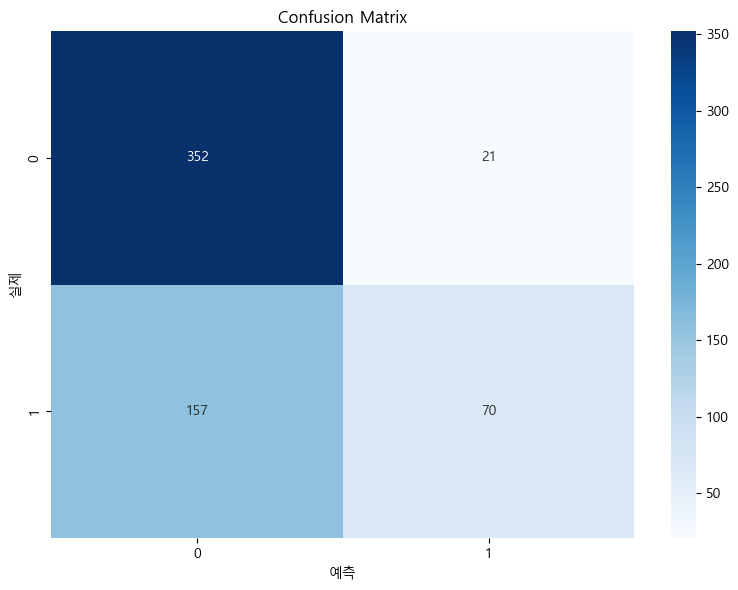

In [139]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False 

# 예측
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 혼동행렬 계산
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))           # 혼동행렬 생성
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('예측')
plt.ylabel('실제')
plt.tight_layout()
plt.show()


## 모델 평가 및 결과 해설

- 본 모델은 전체 정확도 70.3%를 기록하였고, 이탈 고객(1)에 대한 F1-score는 0.44로 나타났다.
- 혼동행렬을 보면, 잔류 고객(0)은 94%의 높은 재현율로 잘 예측했으나, 이탈 고객은 31%만 정확히 맞췄다.
- 이탈 예측 precision이 0.77로 비교적 높아, 모델이 "이탈 예측"을 보수적으로 하는 경향이 있었다.
- 잔류 고객 예측 성능이 상대적으로 더 높게 나왔고, 이탈 고객 탐지율(재현율)은 다소 아쉬운 편이었다.
- 전반적으로 실제 서비스 환경에서 잔류 고객 식별에는 무리가 없으나, 이탈 고객을 더 잘 잡기 위해 추가적인 피처 확보나 후속 모델 개선이 필요하다고 판단된다.
